# RANSAC


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


## Utilities functions


In [11]:
def reg_plot(ax, X, y, y_pred, title, color="steelblue"):
    ax.scatter(X, y, c=color, edgecolor="white", s=70)
    ax.plot(X, y_pred, color="black", lw=2)
    ax.set_title(title)
    return


def res_plot(ax, y_pred, y, title, color="steelblue"):
    ax.scatter(y_pred, y_pred - y, c=color, marker="o", edgecolor="white", s=70)
    ax.hlines(y=0, xmin=-10, xmax=50, color="black", lw=2)
    ax.axes.set_aspect("equal")
    ax.set_title(title)


def store_results(df, model_name, model, y_train, y_test, y_train_pred, y_test_pred):

    MSE_train = mean_squared_error(y_train, y_train_pred)
    MSE_test = mean_squared_error(y_test, y_test_pred)

    R2_train = r2_score(y_train, y_train_pred)
    R2_test = r2_score(y_test, y_test_pred)

    data = {
        "Model": model_name,
        "Coef": model.coef_[0],
        "Intercept": model.intercept_,
        "MSE Train": [MSE_train],
        "MSE Test": [MSE_test],
        "R2 Train": [R2_train],
        "R2 Test": [R2_test],
    }
    dft = pd.DataFrame(data=data)
    return df.append(dft, ignore_index=True)


In [12]:
def run_model(model, model_name, X_train, y_train, X_test, y_test, df):

    # Fitting model
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Point considered by the model
    inlier_mask = model.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    # Plotting
    fig, ax = plt.subplots(
        1, 2, figsize=(10, 5), constrained_layout=True, sharex=True, sharey=True
    )
    reg_plot(ax=ax[0], X=X_train, y=y_train, y_pred=y_train_pred, title="Train")
    ax[0].scatter(
        X_train[inlier_mask],
        y_train[inlier_mask],
        c="salmon",
        edgecolor="white",
        marker="o",
        label="Inliers",
        s=70,
    )
    reg_plot(
        ax=ax[1],
        X=X_test,
        y=y_test,
        y_pred=y_test_pred,
        title="test",
        color="limegreen",
    )
    fig.supxlabel("Lower status of the population [LSTAT]")
    fig.supylabel("Median value of homes in $1000s [MEDV]")

    # Residual plot
    # fig, ax = plt.subplots(
    #     1, 2, figsize=(9, 5), constrained_layout=True, sharex=True, sharey=True
    # )
    # res_plot(ax=ax[0], y_pred=y_train_pred, y=y_train, title="Train")
    # res_plot(ax=ax[1], y_pred=y_test_pred, y=y_test, title="Test", color="limegreen")
    # fig.supxlabel("Predicted values")
    # fig.supylabel("Residual")

    df = store_results(
        df=df,
        model=rc.estimator_,  # Need to extract the model out from the wrapper.
        model_name=model_name,
        y_train=y_train,
        y_train_pred=y_train_pred,
        y_test=y_test,
        y_test_pred=y_test_pred,
    )

    return df


## Setting up


In [13]:
# Load data
df = pd.read_excel("housing_data.xlsx",)
df.head()

# Extract data
X = df[["LSTAT"]].values
y = df["MEDV"].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)



## Regression


,Model,Coef,Intercept,MSE Train,MSE Test,R2 Train,R2 Test
0,RANSAC-1,-0.892565,32.596221,39.790242,41.036819,0.530579,0.507157
1,RANSAC-5,-0.723001,29.487122,46.012271,45.703823,0.457175,0.451107
2,RANSAC-10,-0.801176,31.462394,40.889905,41.488038,0.517606,0.501738


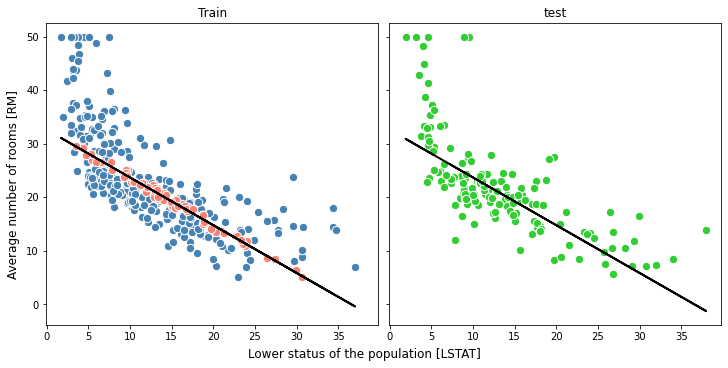

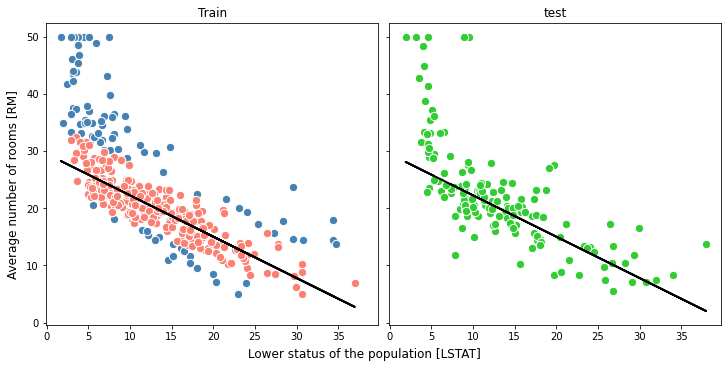

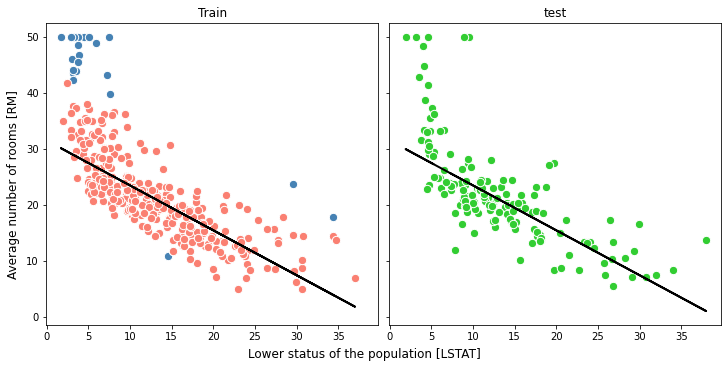

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor

# params = [10, 20, 30, 40, 50]
params = [1, 5, 10]

dfAll = pd.DataFrame()
for param in params:
    rc = RANSACRegressor(
        LinearRegression(),
        max_trials=100,
        min_samples=50,
        loss="absolute_loss",
        residual_threshold=param,
        random_state=0,
    )

    dfAll = run_model(
        model=rc,
        model_name=f"RANSAC-{param}",
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        df=dfAll,
    )

display(dfAll)
